<a href="https://colab.research.google.com/github/tsteifer/transformers-for-triangle-free-graphs/blob/main/Triangle_freeness_testing_with_generalize%20d_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


In [1]:
# Import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import ModuleList, LayerNorm, Dropout, CrossEntropyLoss
import numpy as np
import einops
import tqdm.notebook as tqdm
from opt_einsum import contract

import math


import random
import time
import copy

#from google.colab import drive
from pathlib import Path
import pickle
import os

import matplotlib.pyplot as plt
#%matplotlib inline
import plotly.express as px
import plotly.io as pio
pio.renderers.default='browser'
import plotly.graph_objects as go
from plotly import subplots

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc

import re

# import comet_ml
import itertools

# Definitions

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root=os.path

# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []

    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name

    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output,
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")

    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")

    def forward(self, x):
        return x

# Define network architecture
# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))

    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))

    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PositionalEncoding1(nn.Module):

    def __init__(self, d_model, max_len):
        super().__init__()
        max_len=30
        pe = torch.zeros(max_len*max_len, d_model)
        #position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = 4*torch.exp(torch.arange(d_model/4,).float() * (-math.log(10000.0) / d_model)).unsqueeze(0)
        pos=torch.tensor(np.indices((max_len,max_len)).flatten()).unsqueeze(1)
        #pos=torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        pe[:, 0::4] = torch.sin(pos[:max_len**2] * div_term)#.unsqueeze(1)
        pe[:, 1::4] = torch.cos(pos[:max_len**2] * div_term)#.unsqueeze(1)
        pe[:, 2::4] = torch.sin(pos[max_len**2:] * div_term)#.unsqueeze(0)
        pe[:, 3::4] = torch.cos(pos[max_len**2:] * div_term)#.unsqueeze(0)
        # plt.imshow(pe)
        # plt.show()
        pe=pe.view((max_len*max_len,d_model)).unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        #print(x.size())
        #print(self.pe.size())
        #print(self.pe[:,:x.size(1), :])
        x = x + self.pe[:,:x.size(1), :]
        return x#self.dropout(x)


class PosEmbed2D(nn.Module):

    def __init__(self, d_model, max_len):
        super().__init__()
        sqn=int(np.sqrt(max_len))
        self.peX = nn.Parameter(torch.randn(sqn,d_model))
        self.peY = nn.Parameter(torch.randn(sqn,d_model))
        #position = torch.tensor(np.indices((sqn,sqn)))
        #position = position.view((2,sqn**2))
        # print(self.peX.size())
        # print(position.size())
        #self.register_buffer('position',position)


    def forward(self, x):
        # print(x.size())
        sqn=int(np.sqrt(x.size(1)))
        position = torch.tensor(np.indices((sqn,sqn)))
        position = position.view((2,sqn**2))
        x = x + self.peX[position[0,:],:].unsqueeze(0)
        x = x + self.peY[position[1,:],:].unsqueeze(0)
        return x#self.dropout(x)

class PosEmbed2D1Hot(nn.Module):

    def __init__(self, d_model, max_len):
        super().__init__()
        sqn=int(np.sqrt(max_len))
        pe=F.one_hot(torch.arange(0, sqn), num_classes=d_model)
        #self.peY=F.one_hot(torch.arange(0, sqn), num_classes=d_model)
        self.register_buffer('peX', pe)
        self.register_buffer('peY', pe)

    def forward(self, x):
        # print(x.size())
        sqn=int(np.sqrt(x.size(1)))
        position = torch.tensor(np.indices((sqn,sqn)))
        position = position.view((2,sqn**2))
        x = x + self.peX[position[0,:],:].unsqueeze(0)
        x = x + self.peY[position[1,:],:].unsqueeze(0)
        return x#self.dropout(x)

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon

    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()
        self.hook_k2 = HookPoint()
        self.hook_q2 = HookPoint()
        self.hook_v2 = HookPoint()
        self.hook_z2 = HookPoint()
        self.hook_attn2 = HookPoint()
        self.hook_attn_pre2 = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
       # attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_pre/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

class TripletAttention(nn.Module):
    def __init__(self, d_model, num_heads,model,qkv_bias=False, qk_scale=None):
        #super(TripleAttention, self).__init__()
        super().__init__()
        self.num_heads = num_heads
        head_dim = d_model // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.w = nn.Linear(d_model, d_model * 4, bias=qkv_bias)
        self.proj = nn.Linear(1 * d_model, d_model)

    def forward(self, x, attention_mask=None):
        # x shape: [B, N*N, C]
        # attention_mask shape: [B, N]
        B, NN, C = x.shape
        H = self.num_heads
        D = C // H

        # Calculate N from NN (N*N)
        N = int((NN) ** 0.5)

        w = self.w(x).reshape(B, NN, 4, H, D).permute(2, 0, 3, 1, 4)
        a, b, c, v = w[0], w[1], w[2], w[3]

        # Calculate attention matrices (preserving original computation)
        AB = contract('bhid,bhjd->bhij', a, b) * self.scale
        CD = contract('bhid,bhkd->bhik', a, c) * self.scale
        EF = contract('bhjd,bhkd->bhjk', b, c) * self.scale

        # Compute A_IJK using addition (as in original)
        A_IJK = AB.unsqueeze(-1) + CD.unsqueeze(-2) + EF.unsqueeze(-3)

        # Handle attention mask
        if attention_mask is not None:
          # Create mask for flattened sequence
          # [B, N] -> [B, N*N]
          flat_mask = (attention_mask.unsqueeze(-1) *
                      attention_mask.unsqueeze(-2)).reshape(B, -1)

          # Expand mask to match A_IJK dimensions [B, 1, NN, NN, N*N]
          mask_5d = (flat_mask.unsqueeze(1)  # Add head dimension
                    .unsqueeze(-1).unsqueeze(-1))  # Add dimensions for j, k

          # Apply mask
          mask_value = -1e9
          # A_IJK = torch.where(mask_5d.bool(), A_IJK, torch.tensor(
          #     mask_value, device=A_IJK.device))
          A_IJK = torch.where(mask_5d.bool(), torch.tensor(
              mask_value, device=A_IJK.device), A_IJK)

        # Use exponential and manual normalization
        e_AIJK = torch.exp(A_IJK)

        # Calculate normalization factor (as in original)
        norm_factor = e_AIJK.sum(dim=(-2, -3), keepdim=True).clamp(min=1e-6)
        e_AIJK_normalized = e_AIJK / norm_factor

        # Compute outputs (preserving original computation)
        x1 = contract('bhijk,bhjd->bhid', e_AIJK_normalized, v)
        x2 = contract('bhijk,bhkd->bhid', e_AIJK_normalized, v)

        # Concatenate x1 and x2
        #x = torch.cat([x1, x2], dim=-1)
        x=x1*x2

        # Reshape to final output
        x = x.transpose(1, 2).reshape(B, NN, C)

        # Project and apply dropout
        x = self.proj(x)
        # x = self.proj_drop(x)

        return x


class EdgeAttentionEncoder(nn.Module):
    def __init__(self,d_model, num_heads,model):
        super().__init__()
        # We assume d_v always equals d_k
        self.model = model
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.linears = _get_clones(nn.Linear(d_model, d_model), 5)
        self.reduce_dim_key = nn.Linear(2*d_model,d_model)
        self.reduce_dim_value = nn.Linear(2*d_model,d_model)
        self.attn = None

    def forward(self, state, mask=None):
        num_batches = state.size(0)
        num_nodes = int(np.sqrt(state.size(1)))
        device = state.device
        #state=state.view(num_batches,num_nodes,num_nodes,self.d_model)
        query, key, value = state, state, state

        left_k, right_k, left_v, right_v = [l(x) for l, x in zip(self.linears, (key, key, value, value))]
        left_k = left_k.view(num_batches, num_nodes, num_nodes, self.num_heads, self.d_k)
        right_k = right_k.view_as(left_k)
        left_v = left_v.view_as(left_k)
        right_v = right_v.view_as(left_k)

        scores = torch.einsum("bxahd,bayhd->bxayh",left_k,right_k) / math.sqrt(self.d_k)
        #scores=scores*0

        val = torch.einsum("bxahd,bayhd->bxayhd",left_v,right_v)

        att = F.softmax(scores,dim=2)


        x = torch.einsum("bxayh,bxayhd->bxyhd",att,val)
        x = x.view(num_batches,num_nodes*num_nodes,self.d_model)
        return self.linears[-1](x)

def _get_clones(module, N):
    return ModuleList([copy.deepcopy(module) for i in range(N)])

def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError("activation should be relu/gelu, not {}".format(activation))

# Classifier
class Classify(nn.Module):
    def __init__(self, d_model, model):
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(in_features=d_model,out_features=1)
        #self.ln = LayerNorm(d_mlp, model=self.model)

    def forward(self, x):
        x = self.classifier(x)
        return x

# Output as 2 Logits
class GetLogits(nn.Module):
    def __init__(self, d_model, model):
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(in_features=d_model,out_features=2)
        #self.ln = LayerNorm(d_mlp, model=self.model)

    def forward(self, x):
        x = self.classifier(x)
        return x

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        '''self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(1, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(1))'''
        self.A=nn.Linear(d_model,d_mlp)
        self.B=nn.Linear(d_mlp,d_model)
        self.act_type = act_type
        self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']

    def forward(self, x):
        #x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        x=self.A(x)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x=self.B(x)
        #x = self.hook_post(x)
        #x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, mode, model):
        super().__init__()
        self.model = model
        #self.ln1 = LayerNorm(d_model, model=self.model)
        if mode=='Edge':
            self.attn = EdgeAttentionEncoder(d_model, num_heads,model=self.model)
        if mode=='Triplet':
            self.attn = TripletAttention(d_model, num_heads,model=self.model)
        if mode=='Standard':
            self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        #self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        #self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        #self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        #x = self.dropout(x)
        #x = self.ln1(x)
        x = self.attn(x)
        x = self.mlp(x)

        # x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        # x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x



# Full transformer
class Transformer(nn.Module):
    def __init__(self, sqn, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False,use_ln=True, output='logits', mode='Standard'):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache
        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PositionalEncoding1(d_model,sqn)
        #self.pos_embed = PosEmbed2D(d_model,n_ctx)
        #self.pos_embed = PosEmbed2D1Hot(d_model,n_ctx)
        #PosEmbed2D1Hot
        #self.block = TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, mode, model=[self])
        num_layers=1
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, mode, model=[self]) for i in range(num_layers)])
        self.ln = LayerNorm(d_model, model=[self])
        #self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln
        if output=='binary':
            self.output=Classify(d_model,model=[self])
        if output=='logits':
            self.output=GetLogits(d_model,model=[self])

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        #x = self.ln(x)
        #x = self.unembed(x)
        x=torch.sum(x,axis=-2).unsqueeze(1)
        return self.output(x)#torch.sum(x,axis=-2)
        #x=F.sigmoid(torch.sum(x,axis=-2))
        #return self.output(x)

        #return torch.sum(x,axis=-2)#F.sigmoid(torch.sum(x,axis=-2))

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache

    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')

    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

# Helper functions
def cuda_memory():
    print(torch.cuda.memory_allocated()/1e9)

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    logprobs.size()
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss



def full_loss(model, data):
    global p
    # Take the final position only
    logits = model([i[0] for i in data])[:, -p]
    labels = torch.tensor([i[1] for i in data])#.to('cuda')
    return cross_entropy_high_precision(logits, labels)

def triangle_free(adj):
    sqn=np.shape(adj)[0]
    for a in range(sqn):
        for b in range(sqn):
            if adj[a,b]==1 and not(a==b):
                for c in range(sqn):
                    if not(a==c) and not(b==c):
                        if adj[b,c]==1 and adj[a,c]==1:
                            return 0#False
    return 1#True
    #return int(np.trace(np.dot(np.dot(adj,adj),adj))==0)

def flatten(adj):
    #print(np.shape(adj))
    #print(len(adj[np.tril_indices(np.shape(adj)[0],-1)]))
    return adj.reshape((np.shape(adj)[0]*np.shape(adj)[1]))
    #return adj[np.tril_indices(np.shape(adj)[0],-1)]


def gen_train_test(num,size, mu=250):
    data=[]
    sqn=int(np.sqrt(num))
    n=int(sqn/3)
    inds=np.arange(sqn)
    for k in range(mu):
        for sample in range(500):
            adj=np.zeros((sqn,sqn))
            #inds=np.arange(sqn)
            np.random.shuffle(inds)
            pp=6/sqn
            for i in range(n):
                for j in range(n):
                    adj[inds[i],inds[j+n]]=random.choices([0,1],[1-pp,pp],k=1)[0]
                    adj[inds[i],inds[j+2*n]]=random.choices([0,1],[1-pp,pp],k=1)[0]
                    adj[inds[i+n],inds[j+2*n]]=random.choices([0,1],[1-pp,pp],k=1)[0]
            adj=np.tril(adj.T,-1) + np.triu(adj, 1)
            adj[np.diag_indices_from(adj)]=0
            x=flatten(adj)
            y=triangle_free(adj)
            data.append([x,y])
    return data

def gen_validation(num,p, mu=250):
    data=[]
    sqn=int(np.sqrt(num))
    #inds=np.arange(sqn)
    for sample in range(mu*500):
        adj=np.zeros((sqn,sqn))
        for a in range(sqn):
            for b in range(sqn):
                adj[a,b]=random.choices([0,1],[1-p,p],k=1)[0]
        adj=np.tril(adj.T,-1) + np.triu(adj, 1)
        adj[np.diag_indices_from(adj)]=0
        x=flatten(adj)
        y=triangle_free(adj)
        data.append([x,y])
    return data

lr=1e-3 #@param
weight_decay =  1e-3 #@param
nodes=15
p=nodes*nodes

num_epochs = 1000 #@param
save_models = False #@param
save_every = 100 #@param

seed = 0 #@param
d_vocab = 2
n_ctx = p

d_model = 8
d_mlp = 4*d_model
num_heads = 1
assert d_model % num_heads == 0
d_head = d_model//num_heads

act_type = 'ReLU' #@param ['ReLU', 'GeLU']

train_nodes=[15]

train_sets=[]

for node in train_nodes:
    train_sets.append(gen_train_test(node**2, seed))

test = gen_validation(15*15, 0.1)

def executeTraining(d_model,modde,output='logits'):
    c=0.
    c_train=[]
    emp_losses=[]
    gen_losses=[]
    for i in range(len(train_nodes)):
        emp_losses.append([])
        c0=0
        for k in range(len(train_sets[i])):
            if train_sets[i][k][1]==1:
                c0+=1
        c_train.append(c0/len(train_sets[i]))
    #c=(c1+c2+c3)/(len(train1)+len(train2))
    #c1=c1/len(train1)
    #c2=c2/len(train2)
    c_valid=0.
    for k in range(len(test)):
        if test[k][1]==1:
            c_valid+=1
    c_valid=c_valid/len(test)
    print('Start')
    model = Transformer(sqn=np.max(train_nodes), d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False,output=output, mode=modde)
    model.to('cuda')
    print('Model defined')
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))#,amsgrad=True)
    #optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))
    run_name = f"Att4Pairs_{int(time.time())}"
    #lossFunction=torch.nn.CrossEntropyLoss()
    lossFunction=torch.nn.BCELoss()
    #lossFunction=torch.nn.MSELoss()
    #lossFunction=torch.nn.BCELoss(weight=torch.tensor(c).to('cuda'))#torch.zeros((32,1))+c)

    #emp_losses={}

    print(f'Run name {run_name}')
    if save_models:
        os.mkdir(run_name)
        #save_dict = {'model':model.state_dict(), 'train_data':train1, 'test_data':test}
        torch.save(save_dict, run_name+'/init.pth')
    for epoch in range(num_epochs):
        for i in range(len(train_nodes)):
            random.shuffle(train_sets[i])
        #random.shuffle(train1)
        #random.shuffle(train2)
        batch_size=128
        for batch in range(int(1.0*len(train_sets[0])/batch_size)):
            for o in range(len(train_nodes)):
                data=train_sets[o][batch*batch_size:(batch+1)*batch_size]
                #print(data)
                logits = model(np.array([i[0] for i in data]))[:,-1,:].to(torch.float64).to('cuda')
                #logits = logits.to(torch.float64).to('cuda')
                logits = F.softmax(logits,dim=-1)
                #print(logits)
                #print(logits.size)
                #labels = torch.tensor(np.array([i[1] for i in data])).to('cuda')
                #labels = labels.to(torch.float64).view(labels.size(0),1)
                #labels_ext = torch.zeros(logits.size(0),2, requires_grad=False).to(torch.float64).to('cuda')
                labels_ext = F.one_hot(torch.tensor(np.array([i[1] for i in data]))).to(torch.float64).to('cuda')
                #print([(i,data[i][1]) for i in range(logits.size(0))])
                #labels_ext[np.array([(i,data[i][1]) for i in range(logits.size(0))]).transpose()]=1
                '''print(labels_ext)
                while True:
                  x=1'''
                #prediction_logprobs = torch.gather(logits, index=labels[:, None], dim=-1)
                loss = lossFunction(logits,labels_ext)
                #loss = -torch.mean(prediction_logprobs)
                #loss.requires_grad = True
                loss.backward()
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
        if epoch%100 == 0: print(f"{epoch}_{np.log(loss.item())}")#_{train_acc.item():.4f}_{test_acc.item():.4f}")

        if epoch%100 == 0:
            thr=0.73
            err0=0.
            err1=0.
            for o in range(len(train_nodes)):
                for example in train_sets[o]:
                    #pred=torch.round(model([example[0]]))#.to('cuda')
                    #pred=model([example[0]]).item()#.to('cuda')
                    pred=model([example[0]])[:,-1,:].to(torch.float64).cpu()
                    pred=torch.argmax(F.softmax(pred,dim=-1),dim=-1)
                    if pred>=thr and torch.tensor(example[1])==0:
                        err0+=1
                    if pred<thr and torch.tensor(example[1])==1:
                        err1+=1
                    #err+=int(torch.sum(abs(torch.tensor(example[1])-model([example[0]])[:,-int(p/2):].argmax(axis=-1))))
                print('Empirical error: '+str(train_nodes[o])+' nodes:_'+str(err1/len(train_sets[o])*c_train[o]+err0/len(train_sets[o])*(1-c_train[o])))
                emp_losses[o].append(err1/len(train_sets[o])*c_train[o]+err0/len(train_sets[o])*(1-c_train[o]))

            err0=0.
            err1=0.
            for example in test:
                #pred=torch.round(model([example[0]]))#.to('cuda')
                #pred=model([example[0]]).item()#.to('cuda')
                pred=model([example[0]])[:,-1,:].to(torch.float64).cpu()
                pred=torch.argmax(F.softmax(pred,dim=-1),dim=-1)
                if pred>=thr and torch.tensor(example[1])==0:
                    err0+=1
                if pred<thr and torch.tensor(example[1])==1:
                    err1+=1
            print('Validation error: 12 nodes:_'+str(err1/len(test)*c_valid+err0/len(test)*(1-c_valid)))
            gen_losses.append(err1/len(test)*c_valid+err0/len(test)*(1-c_valid))
    if not save_models:
        os.mkdir(run_name)
    save_dict = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'loss': loss,
        'epoch': epoch,
    }
    torch.save(save_dict, run_name+'/'+f"final.pth")
    print(f"Done")
    for o in range(len(train_nodes)):
        plt.plot(np.arange(0,1000,100),emp_losses[o],label='nodes='+str(train_nodes[o]))
    plt.plot(np.arange(0,1000,100),gen_losses,label='nodes=12')
    plt.legend()
    plt.show()

'''train1 = gen_train_test(15*15, seed)
#train2 = gen_train_test(p, seed)
#test = gen_train_test(p, seed)
train2 = gen_train_test(9*9, seed)
train3 = gen_train_test(18*18, seed)
test = gen_train_test(12*12, seed)
print("How many triangle-free graphs in the sample?")
c=0.
for k in range(len(train1)):
    if train1[k][1]==1:
        c+=1
print(c/len(test))'''
c=0
for k in range(len(test)):
    if test[k][1]==1:
        c+=1
print(c/len(test))



0.671936


# Experiments

---


Eksperyment ze standardową atencją, wykres przedstawia błąd empiryczny i walidacyjny w funkcji kolejnych epok.

Start
Model defined
Run name Att4Pairs_1733678558
0_-0.5893517612614438


<ipython-input-2-8b589791bde4>:57: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)



Empirical error: 15 nodes:_0.13004363584
Validation error: 12 nodes:_0.10151484876800002
100_-0.6785353914950201
Empirical error: 15 nodes:_0.12170929241600001
Validation error: 12 nodes:_0.10351077376000001
200_-0.6726221512141779
Empirical error: 15 nodes:_0.114548183808
Validation error: 12 nodes:_0.116921876992
300_-0.9939829387363047
Empirical error: 15 nodes:_0.116481275904
Validation error: 12 nodes:_0.10558987008000001
400_-0.8093990599797412
Empirical error: 15 nodes:_0.110705389184
Validation error: 12 nodes:_0.117736548352
500_-0.7827335077696822
Empirical error: 15 nodes:_0.11020470553599998
Validation error: 12 nodes:_0.11207347558399999
600_-0.8117408226843733
Empirical error: 15 nodes:_0.116025778944
Validation error: 12 nodes:_0.107825125376
700_-0.8703602913259176
Empirical error: 15 nodes:_0.10839838438400001
Validation error: 12 nodes:_0.118163603968
800_-0.7693149385257241
Empirical error: 15 nodes:_0.11268646937599999
Validation error: 12 nodes:_0.11377789542400002

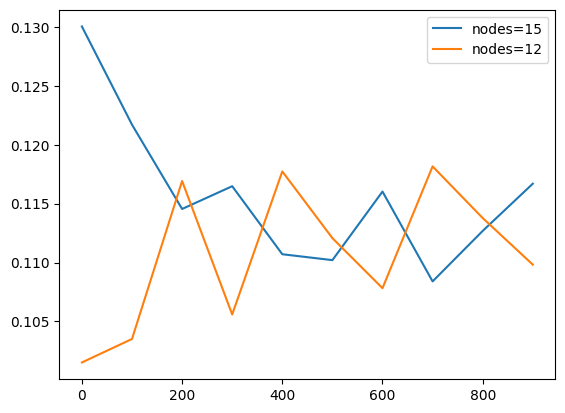

In [3]:
executeTraining(16,modde='Standard',output='logits') #250x50 examples in training and validation datasets

Eksperyment z uogólnioną atencją, wykres przedstawia błąd empiryczny i walidacyjny w funkcji kolejnych epok.

Start
Model defined
Run name Att4Pairs_1733346690
0_-0.6009685857142604


<ipython-input-3-8b589791bde4>:57: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)



Empirical error: 15 nodes:_0.132754373248
Validation error: 12 nodes:_0.094835489664
100_-14.789737532705898
Empirical error: 15 nodes:_2.316736e-05
Validation error: 12 nodes:_2.615488e-05
200_-28.574508643724148
Empirical error: 15 nodes:_0.0
Validation error: 12 nodes:_0.0
300_-23.133565479921128
Empirical error: 15 nodes:_0.0
Validation error: 12 nodes:_0.0
400_-29.326977056286733
Empirical error: 15 nodes:_0.0
Validation error: 12 nodes:_0.0
500_-23.199793409611704
Empirical error: 15 nodes:_0.0
Validation error: 12 nodes:_0.0
600_-24.690248976808142
Empirical error: 15 nodes:_0.0
Validation error: 12 nodes:_0.0
700_-21.796758764286565
Empirical error: 15 nodes:_0.0
Validation error: 12 nodes:_0.0
800_-22.58650328571897
Empirical error: 15 nodes:_0.0
Validation error: 12 nodes:_0.0
900_-27.398567910082328
Empirical error: 15 nodes:_0.0
Validation error: 12 nodes:_0.0
Done


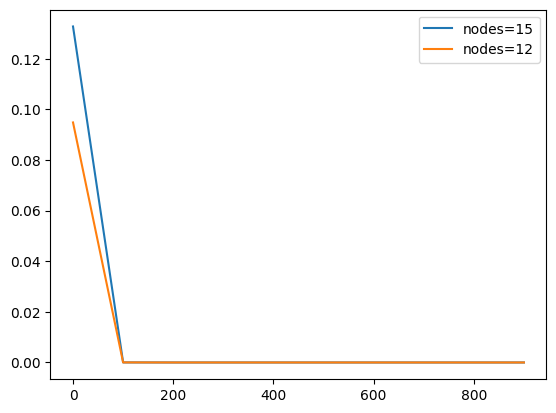

In [ ]:
executeTraining(16,modde="Edge",output='logits') #250x50 examples again